In [2]:
from util import go_to_project_root
go_to_project_root()

CWD cambiado a la raíz del proyecto: /home/epsilon/Documents/doctorado/S2/ENSTA630/tareas/HW2


# Problema 1

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from source.fit.inference.test_chow import test_chow

from source.data.loaders import create_dataset
from source.models.var import VAR
from source.data.transform import create_var_dataset
from source.display.hw import hw2 as plots
from source.display.hw.hw1 import save_figure
from source.fit.bootstrap import run_bootstrap_mp

%load_ext autoreload
%autoreload 2

### Cargar datos

In [4]:
path = './data/base_25.xls'
dataset = create_dataset(path, problem=5)

[INFO] ¡Datos cargados exitosamente!


In [29]:
i_reshaped = dataset['i'][12:]
X = np.vstack([dataset['y'], dataset['pi'], i_reshaped]).T
X = np.vstack([dataset['pi'], i_reshaped, dataset['y']]).T

✅ Figura guardada exitosamente en ./presentation/figures/hw2/data.pdf


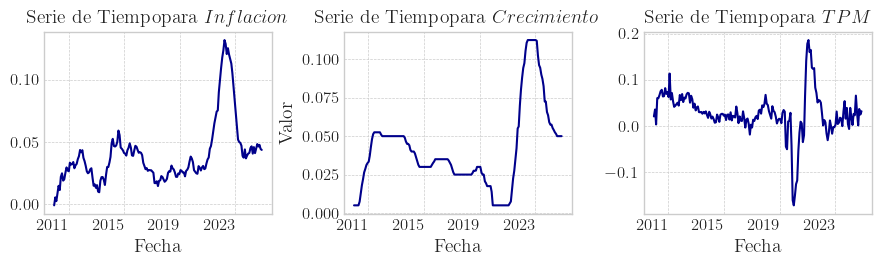

In [30]:
fig, axes = plt.subplots(1,3, figsize=(9, 3), sharex=True)
plots.plot_time_series(X, 
                       dates=dataset['t'][12:],
                       variable_names=['Inflacion', 
                                       'Crecimiento',
                                       'TPM'],
                        fig=fig, axes=axes)

save_figure(fig, './presentation/figures/hw2/data.pdf')

### Seleccionando el mejor modelo

In [31]:
from source.fit.model_selection import hannan_rissanen, hannan_rissanen_con_ljungbox

In [32]:
metrics = hannan_rissanen(X, 
                        max_rezagos=30,
                        verbose=False)
metrics = hannan_rissanen_con_ljungbox(X, 
                        max_rezagos=20,
                        verbose=False)
metrics

Evaluando órdenes de rezago del 1 al 30...
Evaluación completada.


,AIC,BIC,HQIC,Ljung-Box p-valor
p,,,,
1,-30.528904,-30.319234,-30.443922,1.240780e-23
2,-30.935721,-30.567419,-30.786430,3.213054e-04
3,-31.023798,-30.495665,-30.809701,2.561731e-04
4,-31.012136,-30.322957,-30.732728,6.988085e-06
5,-31.000042,-30.148586,-30.654813,6.187072e-06
6,-31.041306,-30.026329,-30.629741,5.574658e-09
7,-31.043252,-29.863489,-30.564826,1.727808e-08
8,-31.090748,-29.744922,-30.544933,3.019201e-06
9,-31.182667,-29.669481,-30.568926,1.463859e-04


✅ Figura guardada exitosamente en ./presentation/figures/hw2/p2/model_selection.pdf


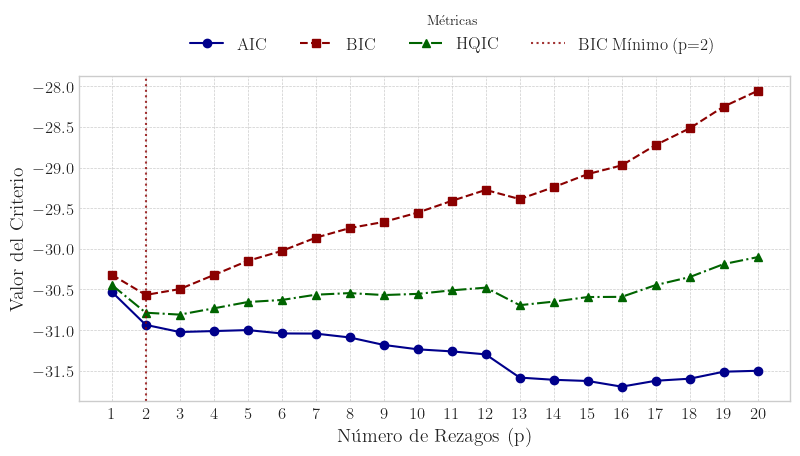

In [33]:
fig, ax = plt.subplots(figsize=(9, 4))
fig, ax  = plots.graficar_criterios_var(metrics, fig=fig, ax=ax)
save_figure(fig, './presentation/figures/hw2/p2/model_selection.pdf')

### Modelo

In [34]:
p = 2          # rezagos
n = X.shape[1] # numero de variables
model = VAR(inp_dim=n, 
            c=0,
            p=p)
_ = model.fit(X)
model._is_stationary()

np.True_

In [ ]:
# Define la función que extrae la estadística
get_irf_fn = lambda m: m.get_irf(H=24, method='cholesky')

# Ejecuta el bootstrap PARALELIZADO
irf_point, irf_lower, irf_upper = run_bootstrap_mp(
    fitted_var=model,
    statistic_fn=get_irf_fn,
    n_replications=10000,
    confidence_level=0.95,
    n_jobs=-1 # Usa todos los cores disponibles
)


Iniciando simulación paralela con 10000 iteraciones en 8 procesos...


Bootstrap en Paralelo: 100%|██████████| 10000/10000 [00:21<00:00, 466.01it/s]



Cálculo finalizado. 10000/10000 réplicas exitosas.


✅ Figura guardada exitosamente en ./presentation/figures/hw2/p2/irf_cholesky_3.pdf


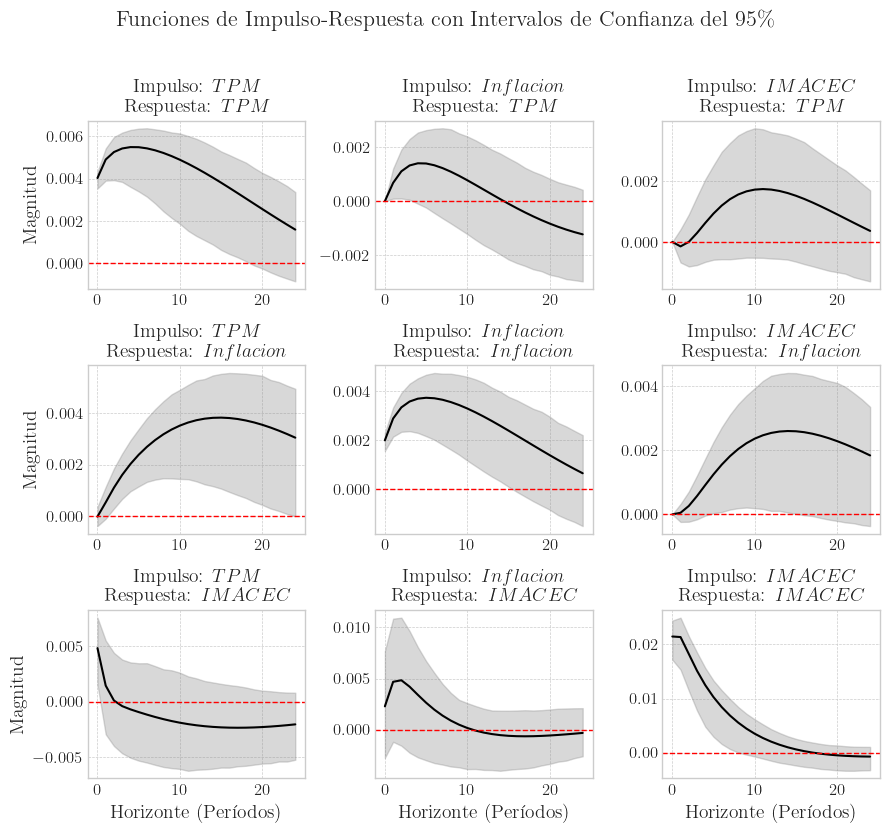

In [36]:
fig, axes = plt.subplots(3, 3, figsize=(9,9))
fig, axes = plots.plot_irf_with_confidence_bands(
    irf_point_estimate=irf_point,
    irf_lower_band=irf_lower,
    irf_upper_band=irf_upper,
    variable_names=['TPM', 'Inflacion', 'IMACEC'],
    axes=axes, fig=fig
)
save_figure(fig, './presentation/figures/hw2/p2/irf_cholesky_3.pdf')

### Evaluando el efecto orden

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

i_reshaped = dataset['i'][12:]
lista_de_datos = [dataset['y'], dataset['pi'], i_reshaped]
nombres_de_variables = ['y', 'pi', 'i'] # Para ver el resultado más claro

combinaciones_de_datos = list(itertools.permutations(lista_de_datos))

print(f"Se generaron {len(combinaciones_de_datos)} combinaciones de datos para el modelo VAR.")
print("Cada combinación es una tupla que contiene los arrays en un orden diferente.")
print("-" * 40)


irf_point_orders = [] 
for i, currorder in enumerate(combinaciones_de_datos):
    print(f"Ejecutando modelo con orden de variables #{i+1}...")
    
    X = np.vstack(currorder).T
    
    print(f"  -> La matriz de datos X tiene la forma: {X.shape}") 
    
    p = 2
    n = X.shape[1]
    model = VAR(inp_dim=n, c=0, p=p)
    _ = model.fit(X)
    
    get_irf_fn = lambda m: m.get_irf(H=24, method='cholesky')
    
    irf_point, irf_lower, irf_upper = run_bootstrap_mp(
        fitted_var=model,
        statistic_fn=get_irf_fn,
        n_replications=1000,
        confidence_level=0.95,
        n_jobs=-1
    )
    irf_point_orders.append(irf_point)
    print("-" * 40)


Se generaron 6 combinaciones de datos para el modelo VAR.
Cada combinación es una tupla que contiene los arrays en un orden diferente.
----------------------------------------
Ejecutando modelo con orden de variables #1...
  -> La matriz de datos X tiene la forma: (185, 3)
Iniciando simulación paralela con 1000 iteraciones en 8 procesos...


Bootstrap en Paralelo: 100%|██████████| 1000/1000 [00:03<00:00, 266.89it/s]



Cálculo finalizado. 1000/1000 réplicas exitosas.
----------------------------------------
Ejecutando modelo con orden de variables #2...
  -> La matriz de datos X tiene la forma: (185, 3)
Iniciando simulación paralela con 1000 iteraciones en 8 procesos...


Bootstrap en Paralelo: 100%|██████████| 1000/1000 [00:03<00:00, 312.09it/s]



Cálculo finalizado. 1000/1000 réplicas exitosas.
----------------------------------------
Ejecutando modelo con orden de variables #3...
  -> La matriz de datos X tiene la forma: (185, 3)
Iniciando simulación paralela con 1000 iteraciones en 8 procesos...


Bootstrap en Paralelo: 100%|██████████| 1000/1000 [00:03<00:00, 308.42it/s]



Cálculo finalizado. 1000/1000 réplicas exitosas.
----------------------------------------
Ejecutando modelo con orden de variables #4...
  -> La matriz de datos X tiene la forma: (185, 3)
Iniciando simulación paralela con 1000 iteraciones en 8 procesos...


Bootstrap en Paralelo: 100%|██████████| 1000/1000 [00:03<00:00, 316.72it/s]



Cálculo finalizado. 1000/1000 réplicas exitosas.
----------------------------------------
Ejecutando modelo con orden de variables #5...
  -> La matriz de datos X tiene la forma: (185, 3)
Iniciando simulación paralela con 1000 iteraciones en 8 procesos...


Bootstrap en Paralelo: 100%|██████████| 1000/1000 [00:03<00:00, 280.44it/s]


Cálculo finalizado. 1000/1000 réplicas exitosas.
----------------------------------------
Ejecutando modelo con orden de variables #6...
  -> La matriz de datos X tiene la forma: (185, 3)
Iniciando simulación paralela con 1000 iteraciones en 8 procesos...



Bootstrap en Paralelo: 100%|██████████| 1000/1000 [00:03<00:00, 275.63it/s]



Cálculo finalizado. 1000/1000 réplicas exitosas.
----------------------------------------


✅ Figura guardada exitosamente en ./presentation/figures/hw2/p2/efecto_orden.pdf


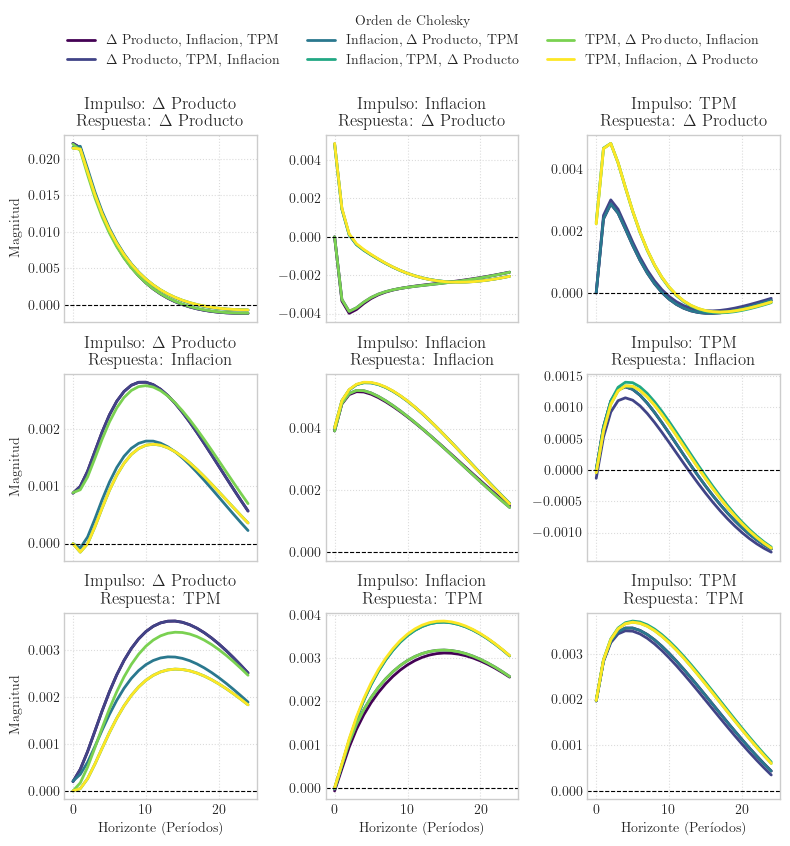

In [ ]:
variables_canonicas = [r'$\Delta$ Producto', r"Inflacion", r'TPM']
permutaciones_nombres = list(itertools.permutations(variables_canonicas))

fig, axs = plt.subplots(3, 3, figsize=(8, 8), sharex=True)

horizonte = np.arange(irf_point_orders[0].shape[0])

colores = plt.cm.viridis(np.linspace(0, 1, 6))

# Itera sobre la grilla de subplots
for fila_idx, var_respuesta in enumerate(variables_canonicas):
    for col_idx, var_impulso in enumerate(variables_canonicas):
        
        ax = axs[fila_idx, col_idx]

        for k, orden_actual in enumerate(permutaciones_nombres):
            idx_respuesta_modelo = orden_actual.index(var_respuesta)
            idx_impulso_modelo = orden_actual.index(var_impulso)
            
            irf_data = irf_point_orders[k][:, idx_respuesta_modelo, idx_impulso_modelo]
            
            etiqueta = ', '.join(orden_actual)
            ax.plot(horizonte, irf_data, label=etiqueta, color=colores[k], linewidth=2)

        ax.axhline(0, color='black', linestyle='--', linewidth=0.8)
        ax.set_title(f'Impulso: {var_impulso}\nRespuesta: {var_respuesta}')
        ax.grid(True, linestyle=':', alpha=0.7)
        if fila_idx == 2:
            ax.set_xlabel('Horizonte (Períodos)')
        if col_idx == 0:
            ax.set_ylabel('Magnitud')

# Crea una única leyenda para toda la figura para no saturar el gráfico
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.97, 1.06), title="Orden de Cholesky", ncols=3)

plt.tight_layout(rect=[0, 0, 1, 0.96])
save_figure(fig, './presentation/figures/hw2/p2/efecto_orden.pdf')